# Pipeline test with RCA FISH - Version 4

**How Version 3 differs from Versions 1 and 2:** V3 test images are filtered.

- Inputs:
    - 1 RCA FISH sample image
    - expert annotations of the sample image
    - 3 RCA FISH test images
- Operations: 
    - **Part 1**: parameter extraction from sample image
    - **Part 2**: blob detection on test images, using parameter extraction
    - **Part 3**: cropping of test images, using parameter extraction
    - **Part 4**: QC and reassembly of turker-annotated crops
    - **Part 5**: evaluation of precision and recall
- Outputs:
    - Consensus turker annotation coordinates
    - Precision and recall analysis
    
# Old stuff: 

## Takeaway: From V1 to V2, recall has increased and precision has decreased.

#### Turker consensus annotation results:
(agreement between worker consensus and “expert”)

|Image|Precision v1|Recall v1|Precision v2|Recall v2|
|------|------|------|------|------|
|ISS_rnd0_ch1_z0	|0.750902		|0.345825	|0.496361	|0.527864
|ISS_rnd0_ch3_z0	|0.655556		|0.471173		|0.494444	|0.529940
|ISS_rnd1_ch1_z0	|0.632743		|0.414493	|0.513274		|0.630435

To see this in the notebook visualized as scatter plots, command + F `Visualize precision and recall.`
To see this in the notebook visualized as scatter plots and with reference points plotted, command + F `Visualize precision and recall, showing reference points`

#### While precision has decreased from v1 to v2, recall has increased and is now better than the baseline recall of blob_log() spot detection, except for the first test image (ISS_rnd0_ch1_z0). Note that when looking at the Jenny's annotations for ISS_rnd0_ch1_z0, Kevin had noted that there were some more spots he would have clicked.

Compare with blob_log()’s performance:

#### blob_log() spot detection results:
(agreement between blob_log() and “expert”)

|Image			|Precision	|Recall
|------|------|------|
|ISS_rnd0_ch1_z0	|0.930178		|0.532544
|ISS_rnd0_ch3_z0	|0.944223		|0.471173
|ISS_rnd1_ch1_z0	|0.956250		|0.443478

To see this in the notebook visualized as plots, command + F `Plot Correct vs. Incorrect, Detected vs. Undetected`

It seems that “poor” turker performance might still be a result of mismatch between "expert" and turker opinions about what a spot should look like. blob_log() learns directly from lots of expert-annotated examples about what a spot should look like and then “plays it safe,” detecting only spots which the “expert” would probably detect but missing a lot of less-obvious spots which the “expert” would probably detect, and therefore ending up with higher precision. The turkers, on the other hand, take more risks and end up with higher recall but lower precision.

**Note:** the turker annotations for round 1 and round 2 are both the same, so the turkers didn’t get better instructions for round 2.

In [45]:
from math import floor, sqrt
from scipy import ndimage, optimize
from skimage import data
from skimage.feature import blob_log
from skimage.color import rgb2gray
from skimage.io import imread
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.neighbors import KDTree
from numpy import pi, r_
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math, random, sys, os
sys.path.insert(0, '../../../FISH-annotation/Annotation')
import util
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation

## User-determined parameters

In [2]:
margin = 4					# margin around each spot, in pixels
correctness_threshold = 4
max_num_crops = 7
colors = ['red', 'orange', 'black', 'green', 'blue', 'purple', 'cyan']

# Part 1: Parameter Extraction

### This section of the pipeline:

- Inputs:
    - sample FISH image
    - expert annotations of the image
- Outputs: 
    - parameters specific to RCA FISH for blob detection
        - max sigma: `max_sigma`
        - min sigma: `min_sigma`
        - optimal intensity threshold: `best_threshold`

### Metadata for sample image

In [3]:
sample_img_filename = 'ISS_rnd0_ch0_z0.png'
sample_img_path = os.getcwd() + '/sample_image_filtered/' + sample_img_filename

sample_coords_filename = 'ISS_rnd0_ch0_z0.csv'
sample_coords_path = os.getcwd() + '/sample_image_filtered/' + sample_coords_filename

### View sample image

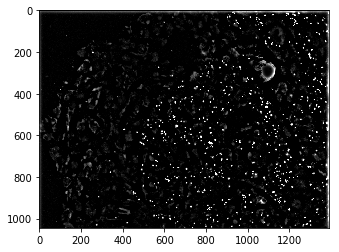

../../../FISH-annotation/Annotation/util.py:187: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ref_points = ref_df.loc[:, ['col', 'row']].as_matrix()


In [4]:
im = imread(sample_img_path)
im_gray = rgb2gray(im)
plt.imshow(im_gray, cmap='gray')
plt.show()

img_height = len(im)
ref_coords = np.genfromtxt(sample_coords_path, delimiter=',')[1:]
ref_kdt = util.csv_to_kdt(sample_coords_path, img_height)

# Find limits on spot size

### Gaussian fit methods
Cell below from https://scipy-cookbook.readthedocs.io/items/FittingData.html.

In [5]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

### Find the size of each spot identified by the expert and take the max and min

In [6]:
sigma_max_list = []
for x, y in ref_coords:

    x_min = int(x)-margin if int(x)-margin >= 0 else 0
    x_max = int(x)+margin if int(x)+margin < im.shape[1] else im.shape[1]-1
    y_min = int(y)-margin if int(y)-margin >= 0 else 0
    y_max = int(y)+margin if int(y)+margin < im.shape[0] else im.shape[0]-1

    little_crop = im[y_min:y_max, x_min:x_max]
    params = fitgaussian(little_crop)
    fit = gaussian(*params)
    (height, x_param, y_param, width_x, width_y) = params
    q = max(width_x, width_y)/2
    if q < 0:
        continue
    sigma_max = math.sqrt(q)
    sigma_max_list.append(sigma_max)

max_sigma = max(sigma_max_list)
min_sigma = min(sigma_max_list)

/usr/local/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


(array([598.,   4.,   2.,   1.,   1.,   0.,   1.,   0.,   0.,   1.]),
 array([ 0.65034242,  2.84537863,  5.04041483,  7.23545104,  9.43048724,
        11.62552345, 13.82055965, 16.01559586, 18.21063206, 20.40566827,
        22.60070447]),
 <a list of 10 Patch objects>)

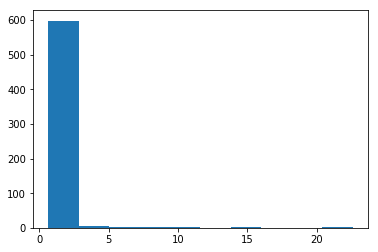

In [7]:
plt.hist(sigma_max_list)

# Find the optimal intensity threshold

### Assign a range of intensity thresholds to test.

In [8]:
thresholds = np.arange(0.1, 0.4, 0.03)

### Run blob detection with a range of thresholds and evaluate precision and recall overall.

In [9]:
best_precision_x_recall = 0
precision_list = []
recall_list = []
for threshold in thresholds:
    
    print('Threshold = %f' % round(threshold, 2))
    
    blobs_log = blob_log(im, min_sigma=min_sigma, max_sigma=max_sigma, num_sigma=10, threshold=threshold)
    blobs = []
    for r, c, sigma in blobs_log:
        blobs.append([c, r])
    blobs_kdt = KDTree(blobs, leaf_size=2, metric='euclidean')	# kdt is a kd tree with all the reference points

    num_blobs_total = len(blobs_log)
    num_ref_total = len(ref_coords)

    correct_blobs = []
    incorrect_blobs = []
    detected_ref = []
    undetected_ref = []

    # correct vs. incorrect

    for r, c, sigma in blobs_log:
        dist, ind = ref_kdt.query([[c, img_height-r]], k=1)
        if dist[0][0] < correctness_threshold:
            correct_blobs.append((r, c, sigma))
        else:
            incorrect_blobs.append((r, c, sigma))

    # detected vs. undetected

    for x, y in ref_coords:
        dist, ind = blobs_kdt.query([[x, y]], k=1)
        if dist[0][0] < correctness_threshold:
            detected_ref.append([x, y])
        else:
            undetected_ref.append([x, y])

    # calculate precision and recall and see if this is the best precision_x_recall we've found yet

    precision = len(correct_blobs)/(len(correct_blobs)+len(incorrect_blobs))
    recall = len(detected_ref)/(len(detected_ref)+len(undetected_ref))
    if (precision * recall) > best_precision_x_recall:
        best_precision_x_recall = precision * recall
        best_precision = precision
        best_recall = recall
        best_threshold = threshold
    precision_list.append(precision)
    recall_list.append(recall)

Threshold = 0.100000
Threshold = 0.130000
Threshold = 0.160000
Threshold = 0.190000
Threshold = 0.220000
Threshold = 0.250000
Threshold = 0.280000
Threshold = 0.310000
Threshold = 0.340000
Threshold = 0.370000
Threshold = 0.400000


Text(0.5,1,'Precision-Recall, intensity threshold = np.arange(0.02, 0.18, 0.01)')

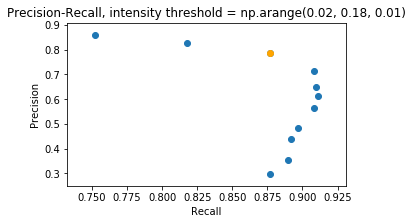

In [10]:
plt.figure(figsize = (5, 3))
plt.scatter(recall_list, precision_list)
plt.scatter([best_recall], [best_precision], c='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall, intensity threshold = np.arange(0.02, 0.18, 0.01)')

### The min sigma, max sigma, and optimal intensity threshold found above with parameter extraction are now considered "tuned" parameters. 
If we are satisfied with them, we can use them with blob_log() on other smFISH chemistries.

In [15]:
print('greatest spot_sigma = %f' % (round(max_sigma, 2)))
print('smallest spot_sigma = %f' % (round(min_sigma, 2)))
print('optimal intensity threshold = %f' % (round(best_threshold, 2)))
if not os.path.exists('./sample_image_filtered/spot_params/'):
    os.mkdir('./sample_image_filtered/spot_params/')
np.savetxt('./sample_image_filtered/spot_params/' + sample_coords_filename, [[min_sigma, max_sigma, best_threshold]], header='min_sigma,max_sigma,best_threshold', delimiter=",", comments='')


greatest spot_sigma = 22.600000
smallest spot_sigma = 0.650000
optimal intensity threshold = 0.340000


# Part 2: Blob Detection

### This section of the pipeline:

- Inputs:
    - parameters specific to RCA FISH for blob detection
        - max sigma: `max_sigma`
        - min sigma: `min_sigma`
        - optimal intensity threshold: `best_threshold`
- Outputs:
    - coordinates of spots detected by blob detection: `blobs` (in `blobs_list`)

### Paths to test images and coords

In [16]:
test_img_filenames = ['ISS_rnd0_ch1_z0', 'ISS_rnd0_ch3_z0', 'ISS_rnd1_ch1_z0']
test_img_paths = [os.getcwd() + '/test_images_filtered/images/%s.png' % x for x in test_img_filenames]
test_coords_paths = [os.getcwd() + '/test_images_filtered/coords/%s.csv' % x for x in test_img_filenames]

### View test images

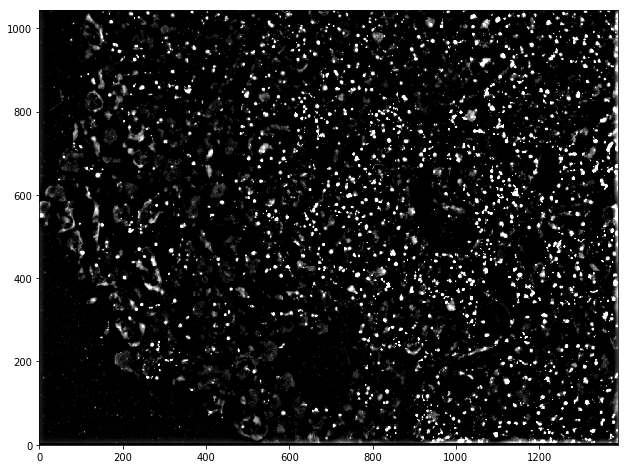

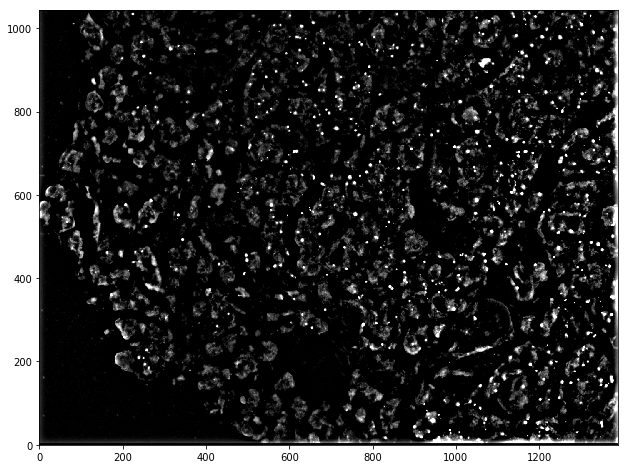

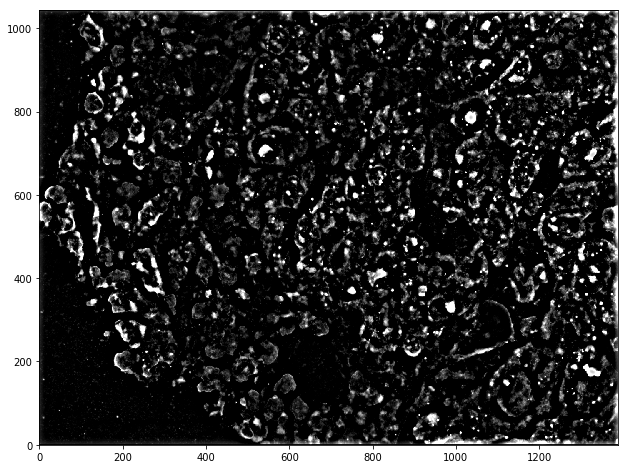

In [17]:
for img_path, coords_path in zip(test_img_paths, test_coords_paths):
    im = imread(img_path)
    im_gray = rgb2gray(im)
    plt.figure(figsize=(12, 8))
    plt.imshow(im_gray, cmap='gray')
    plt.xlim(0, len(im[0]))
    plt.ylim(0, len(im))
    plt.show()

### Run blob_log() on all test images using min_sigma, max_sigma, and best_threshold found above.

In [30]:
blob_params = pd.read_csv('./sample_image_filtered/spot_params/' + sample_coords_filename)
min_sigma = blob_params['min_sigma'][0]
max_sigma = blob_params['max_sigma'][0]
best_threshold = blob_params['best_threshold'][0]
for img_path, coords_path in zip(test_img_paths, test_coords_paths):
    im = imread(img_path)
    im_gray = rgb2gray(im)
    img_height = len(im)
    
    if not os.path.exists('./test_images_filtered/blobs/'):
        os.mkdir('./test_images_filtered/blobs/')
    
    blob_path = img_path.replace('images/', 'blobs/').replace('.png', '.csv')
    
    blobs_log = blob_log(im, max_sigma=max_sigma, min_sigma=min_sigma, num_sigma=10, threshold=best_threshold)
    blobs = [[c, r] for r, c, sigma in blobs_log]
    
    np.savetxt(blob_path, blobs, header='x,y', delimiter=",", comments='')

### Plot Detected Blobs

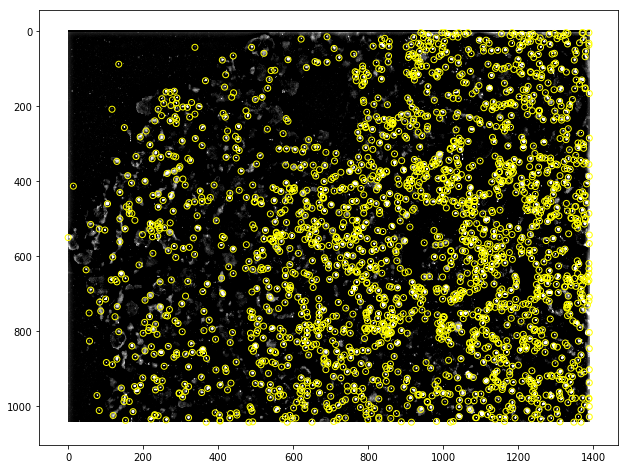

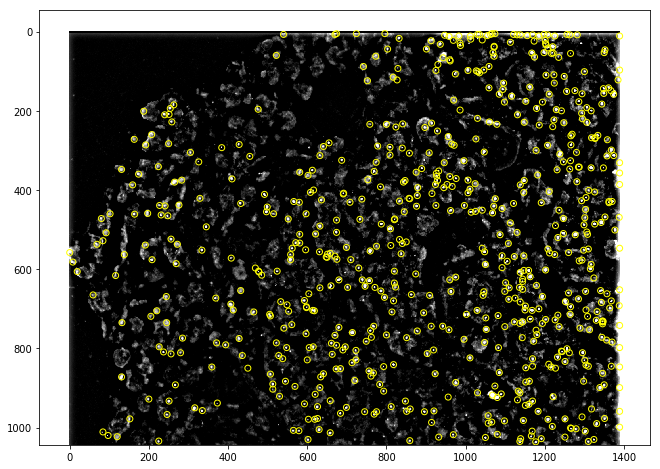

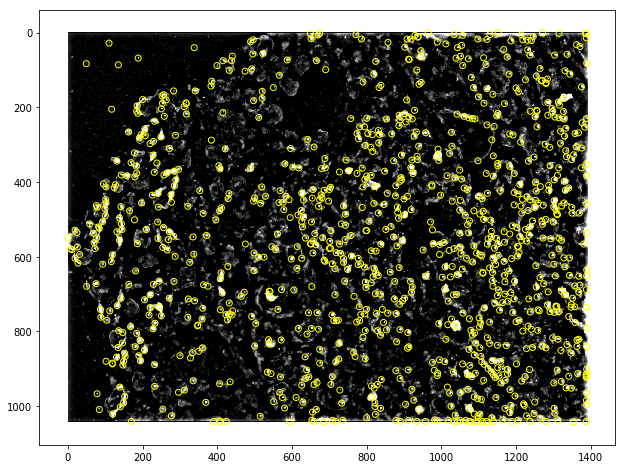

In [33]:
for img_path in test_img_paths:
    
    blob_path = img_path.replace('images/', 'blobs/').replace('.png', '.csv')
    blobs = np.asarray(pd.read_csv(blob_path))
    
    plt.figure(figsize=(12, 8))
    im = imread(img_path)
    plt.imshow(im, cmap='gray')
    for x, y in blobs:
        plt.scatter([x], [y], facecolors='None', edgecolors='yellow')
    plt.show()

# Part 3: Cropping

### This section of the pipeline:

- Inputs:
    - coordinates of spots detected by blob detection: `blobs` (in `blobs_list`)
- Outputs:
    - crops ready to be sent to mechanical turkers

In [46]:
for img_path in test_img_paths:
    
    im = imread(img_path)
    img_height = im.shape[1]
    
    blob_path = img_path.replace('images/', 'blobs/').replace('.png', '.csv')
    blobs = np.asarray(pd.read_csv(blob_path))

    image_width = 1390
    crosshair_ratio = 0.4
    crosshair_arm_length = crosshair_ratio * image_width
    max_num_crops = 4
    max_crowded_ratio = 0.3

    blob_path = img_path.replace('images/', 'blobs/').replace('.png', '.csv')
    blobs = np.asarray(pd.read_csv(blob_path))
    parent_img_name = 'ISS_rnd0_ch1_z0'
    
    util.zoom(blobs, parent_img_name, crosshair_arm_length, max_num_crops, max_crowded_ratio)
    
    